In [1]:
# coding:utf-8
# 进行基于特征工程的运营活动评价

# 相关指标
# 背景 社区类：提高发帖量、评论量、点赞量、转发量、浏览量
# 目的 拉新：新增Cookie、新增注册
#     促活：日活（峰值）、月活（去重求和）、某功能的日活。
#     留存：次日留存、3日留存、7日留存、30日留存
#     品牌：百度指数、微信指数、微博指数、话题阅读量、媒体传播量
#     转化：社区人数、新增社区人数、销售总额、付费订单总量、人数客单价
# 成本 用户激励、员工激励、活动推广、活动开发

In [9]:
import pandas as pd
import re
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
import datetime

# 用于正常显示中文、符号
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 使用ggplot的绘图风格，这个类似于美化，可以通过plt.style.available查看可选值
plt.style.use('ggplot')

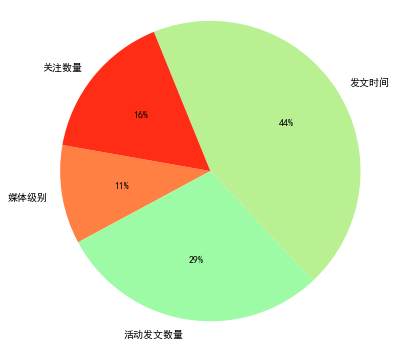

In [3]:
# 评价法对应阶段作为案例
# 知晓——模糊评价法   了解——秩和比法   获取——层次分析法
# 参与——TOPSIS   成长——CIM

# 知晓  阶段，模糊评价法
# 指标：
#     媒体接触度：媒体级别a1、活动发文数量a2、发文时间a3、关注数量a4
#     认知度：内容针对性a5、最高阅读量a6、平均阅读量a7
#     说服度：最高点赞数a8、平均点赞数a9、文章收藏数a10、文章留言数a11、留言点赞数a12
#     二次传播度：被转发数a13、被转载数a14
# 模糊评价主要是将指标权重进行模糊化处理，这里采用模糊权重的层次分析法作为案例。
# Fuzzy AHP
from evaluation.fuzzy_ahp import fuzzy_ahp_method
# 构造判断矩阵
dataset = np.array([
    # a1           a2              a3             a4
    [(1,1,1),      (1/4,1/3,1/2), (1/6,1/5,1/4), (1,1,1)],  # a1
    [(2,3,4),      (1,1,1),       (1/3,1/2,1),   (1,2,3)],  # a2
    [(4,5,6),      (1,2,3),       (1,1,1),       (1,2,3)],  # a3
    [(1,1,1),      (1/3,1/2,1),   (1/3,1/2,1),   (1,1,1)],  # a4
])
# 调用Fuzzy AHP函数
fuzzy_weights, defuzzified_weights, normalized_weights = fuzzy_ahp_method(dataset)

# 模拟数据：将各指标按0-100打分：
# 媒体级别80，活动发文数量85，发文时间65，关注数量90
simulation_data = np.array([80, 85, 65, 90])
total_score = sum(normalized_weights * simulation_data)

shapes = ["媒体级别", "活动发文数量", "发文时间", "关注数量"]
values = normalized_weights

s = pd.Series(values, index=shapes)

from matplotlib import font_manager as fm

labels = s.index
sizes = s.values
explode = (0,0,0,0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots(figsize=(6,6)) # 设置绘图区域大小
a = np.random.rand(1,19)
color_vals = list(a[0])
my_norm = mpl.colors.Normalize(-1, 1) # 将颜色数据的范围设置为 [0, 1]
my_cmap = mpl.cm.get_cmap('rainbow', len(color_vals)) # 可选择合适的colormap，如：'rainbow'

patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=170, colors=my_cmap(my_norm(color_vals)))
ax1.axis('equal')  

# 重新设置字体大小
proptease = fm.FontProperties()
proptease.set_size('medium')
# font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)
plt.savefig('plot/Fuzzy.jpg')
plt.show()

stage_1_value = total_score

d:\program\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     43.23
Date:                Thu, 30 Sep 2021   Prob (F-statistic):            0.00716
Time:                        15:08:21   Log-Likelihood:                 10.810
No. Observations:                   5   AIC:                            -17.62
Df Residuals:                       3   BIC:                            -18.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0529      0.093     -0.569      0.6

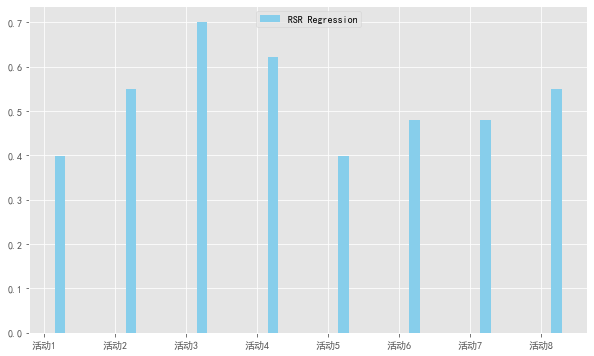

In [4]:
# 了解  阶段，秩和比法
# 指标：
#     渠道：官网b1、公众号b2、头条b3、B站b4、搜索引擎b5
#     学习：文档访问量b6、慕课观看量b7
#     互动：新闻b8、博客b9
#     渠道接触度：渠道发文（视频）数量b10、发文（视频）时间b11、关注数量b12
#     认知度：内容针对性b13、最高阅读量b14、平均阅读量b15、阅读完成率b16、公众号打开率b17
#     说服度：最高点赞数b18、平均点赞数b19、收藏数b20、留言数b21、留言点赞数b22、渠道吸引用户量b23
#     二次传播度：被转发数b24、被转载数b25

# 这里输入了八项活动，并按照次序对八项活动进行评分、排序

# RSR
from evaluation.rsr import rsr,rsrAnalysis

data = pd.DataFrame({'官网': [99, 91, 99, 93, 91, 95, 99, 97],
                     '头条': [60, 67, 91, 59, 30, 71, 41, 39],
                     'B站' : [16, 20, 60, 74, 51, 19, 17, 89],
                     '搜索引擎': [56, 80, 65, 72, 71, 39, 67, 69]},
                    index=["活动1","活动2","活动3","活动4","活动5","活动6","活动7","活动8"],
                    columns=['官网', '头条', 'B站', '搜索引擎'])
Result, Distribution = rsr(data)

ind = np.arange(0,16,2) # the x locations for the groups
width = 0.3  # the width of the bars
 
fig,ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(ind + width, Result['RSR Regression'], width, color='SkyBlue',align='edge', label='RSR Regression')
# Add some text for labels, title and custom x-axis tick labels, etc.

#ax.set_title('Scores by group and gender')
plt.xticks(ind,("活动1","活动2","活动3","活动4","活动5","活动6","活动7","活动8"))
ax.legend(loc='upper center')
fig.savefig('./plot/RSR.jpg')
 
plt.show()

stage_2_value = Result['RSR Regression'][0] * 100

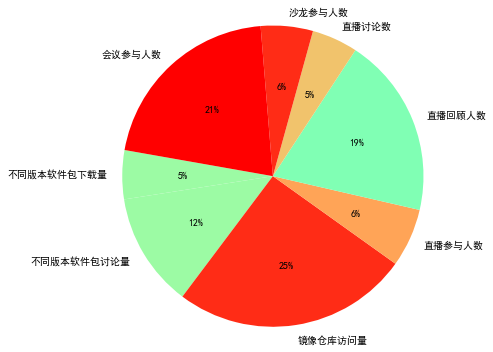

In [5]:
# 获取  阶段，层次分析法
# 指标：
#     下载：不同版本软件包下载量c1、不同版本软件包讨论量c2、镜像仓库访问量c3
#     互动：直播参与人数c4、直播回顾人数c5、直播讨论数c6、 沙龙参与人数c7、会议参与人数c8
# AHP
from evaluation.ahp import ahp_method
# 计算参数
weight_derivation = 'geometric'
# 构造判断矩阵
dataset = np.array([
    # c1   c2    c3    c4   c5    c6    c7   c8
    [1,    1/3,  1/5,  1,   1/4,  1/2,  3,   1/5 ],  # c1
    [3,    1,    1/2,  2,   1/3,  3,    3,   1/2 ],  # c2
    [5,    2,    1,    4,   5,    6,    5,   1/4 ],  # c3
    [1,    1/2,  1/4,  1,   1/4,  1,    2,   1/3 ],  # c4
    [4,    3,    1/5,  4,   1,    3,    2,   3   ],  # c5
    [2,    1/3,  1/6,  1,   1/3,  1,    1/3, 1/4 ],  # c6
    [1/3,  1/3,  1/5,  1/2, 1/2,  3,    1,   1/2 ],  # c7
    [5,    2,    4,    3,   1/3,  4,    2,   1   ]   # c8
])
# 调用AHP函数
weights, rc = ahp_method(dataset, wd=weight_derivation)

shapes = ["不同版本软件包下载量", "不同版本软件包讨论量", "镜像仓库访问量", "直播参与人数",\
        "直播回顾人数", "直播讨论数", "沙龙参与人数", "会议参与人数"]
values = weights

s = pd.Series(values, index=shapes)

# 模拟数据：将各指标按0-100打分：
# 不同版本软件包下载量60，不同版本软件包讨论量89，镜像仓库访问量75，直播参与人数81，
# 直播回顾人数78，直播讨论数79，沙龙参与人数81，会议参与人数91
simulation_data = np.array([60, 89, 75, 81, 78, 79, 81, 91])
total_score = sum(weights * simulation_data)

from matplotlib import font_manager as fm

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = s.index
sizes = s.values
explode = (0,0,0,0,0,0,0,0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots(figsize=(6,6)) # 设置绘图区域大小
a = np.random.rand(1,19)
color_vals = list(a[0])
my_norm = mpl.colors.Normalize(-1, 1) # 将颜色数据的范围设置为 [0, 1]
my_cmap = mpl.cm.get_cmap('rainbow', len(color_vals)) # 可选择合适的colormap，如：'rainbow'

patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=170, colors=my_cmap(my_norm(color_vals)))
ax1.axis('equal')  

# 重新设置字体大小
proptease = fm.FontProperties()
proptease.set_size('medium')
# font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)
plt.savefig('plot/AHP.jpg')
plt.show()

stage_3_value = total_score

activity 1: 0.55
activity 2: 0.67
activity 3: 0.64
activity 4: 0.3


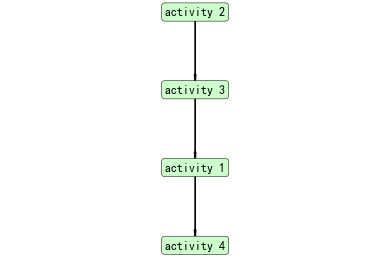

In [10]:
# 参与  阶段，TOPSIS评价法
# 指标：
#     开源社区项目状态：Pull requests数d1、Commit数d2、Issue提交数d3、评论数d4、Star数d5、Fork数d6
#     活动参与情况：活动参与人数d7、活动参与范围d8、活动主题d9
#     开源社区贡献者趋势：贡献者活跃时间d10、活动时间贡献者增量d11、活动时间贡献者停止贡献量d12
# TOPSIS
from evaluation.topsis import topsis_method
# Weights
weights = np.array([[0.1, 0.1, 0.1, 0.05, 0.1, 0.1, 0.1, 0.05, 0.05, 0.1, 0.1, 0.05]])
# Criterion Type: 'max' or 'min'
criterion_type = ['max', 'max', 'max', 'max', 'max', 'max', 'max', 'max', 'max', 'max', 'max', 'min']
    #d1 d2 d3 d4 d5 d6 d7 d8 d9 d10 d11 d12
activity1 = [3, 4, 6, 8, 7, 6, 8, 4, 6, 7,  8,  9]
activity2 = [6, 7, 5, 7, 5, 7, 7, 6, 7, 8,  7,  8]
activity3 = [7, 6, 8, 9, 6, 6, 7, 8, 6, 4,  7,  7]
activity4 = [4, 7, 7, 8, 5, 7, 3, 5, 4, 4,  3,  9]
dataset = np.array([activity1,activity2,activity3,activity4])
# 调用TOPSIS函数
relative_closeness = topsis_method(dataset, weights, criterion_type, graph=True)

stage_4_value = relative_closeness[0]*100

In [7]:
# 成长  阶段，综合指数法
# 指标：
#     技术交流与输出情况：国际论文e1、讲座e2
#     企业/组织分布与劳动力投入情况e3
#     贡献情况：仓库总量e4、仓库新增量e5、CLA签署量e6、CLA签署增量e7、开源社区贡献者趋势e8、开源社区状态e9
# CIM
from evaluation.cim import cim_method

# 建立指标的标准值：
                    #e1    e2   e3    e4   e5   e6   e7
standards = np.array([3,   10,  1000, 300, 50,  300, 30])
data      = np.array([2,   7,   890,  240, 54,  209, 25])
weights   = np.array([0.15,0.15,0.1,  0.1, 0.15,0.15,0.2])

stage_5_value = cim_method(standards, data, weights)

活动评价总分:66.471708


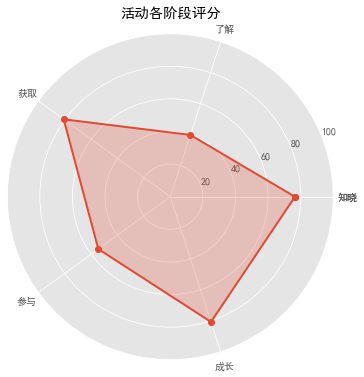

In [8]:
# 构造数据
values = [stage_1_value,stage_2_value,stage_3_value,stage_4_value,stage_5_value]
labels = ['知晓','了解','获取','参与','成长']
 
print("活动评价总分:{:2f}".format(np.mean(values)))
    
# 设置每个数据点的显示位置，在雷达图上用角度表示
angles=np.linspace(0, 2*np.pi,len(values), endpoint=False)
 
# 拼接数据首尾，使图形中线条封闭
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))
labels=np.concatenate((labels,[labels[0]]))

# 绘图
fig=plt.figure(figsize=(6,6))
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2)
# 填充颜色
ax.fill(angles, values, alpha=0.25)
 
# 设置图标上的角度划分刻度，为每个数据点处添加标签
ax.set_thetagrids(angles * 180/np.pi, labels)
 
# 设置雷达图的范围
ax.set_ylim(0,100)
# 添加标题
plt.title('活动各阶段评分')
# 添加网格线
ax.grid(True)
 
plt.show()

In [9]:
# 以上为模拟数据及评价方法示例，以下为部分真实数据预处理及评价代码
def bar_plot(data_dict, xlabel='Time', ylabel='Active degree',on_ticks=False):
    time_len = len(data_dict.keys())
    time_list = list(data_dict.keys())
    frequ_list = list(data_dict.values())
    mpl.rcParams['font.size'] = 10
    fig = plt.figure(1,dpi=300,figsize=(10,6))
    ax = fig.add_subplot(111)
    xs = range(time_len)
    ys = frequ_list
    color =plt.cm.Set2(random.choice(range(plt.cm.Set2.N)))
    ax.bar(xs, ys, color=color, alpha=0.8)
    # ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xs))
    # ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ys))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(False)
    if not on_ticks:
        plt.xticks([],rotation=75)
        plt.yticks([])
    plt.show()

In [10]:
# ----真实数据提取----
# 主要用于提取活动：高效开发者大赛 的信息，
# 活动时间：2020-11-09   2021-04-23
##########已有的输入数据##########
# 活动主题 topic 活动人数 people_number 参与者社区历史活跃数 people_his_active
people_number=547

topic_df = pd.read_excel('./data/topic2020.xlsx')  # 赛题编号  主题标签1  主题标签2
topic_value=topic_df.values
topic_dict={}
topic_label_dict={}
for i in range(len(topic_df)):
    topic_dict[topic_df["name"][i]]=[topic_df["label1"][i]]
    if topic_df["label1"][i] not in topic_label_dict.keys():
        topic_label_dict[topic_df["label1"][i]]=1
    else:
        topic_label_dict[topic_df["label1"][i]]+=1
    if topic_df["label2"][i]:
        topic_dict[topic_df["name"][i]].append(topic_df["label2"][i])
        if topic_df["label2"][i] not in topic_label_dict.keys():
            topic_label_dict[topic_df["label2"][i]]=1
        else:
            topic_label_dict[topic_df["label2"][i]]+=1
        
team_df = pd.read_excel('./data/team2020.xlsx')  # 赛题  队伍  奖项
team_value=team_df.values
team_dict={}
for i in range(len(team_df)):
    if team_df["赛题"][i] not in team_dict.keys():
        team_dict[team_df["赛题"][i]]=[team_df["级别"][i]]
    else:
        team_dict[team_df["赛题"][i]].append(team_df["级别"][i])

start day: 2019-08-21 00:00:00, end day: 2021-07-30 00:00:00


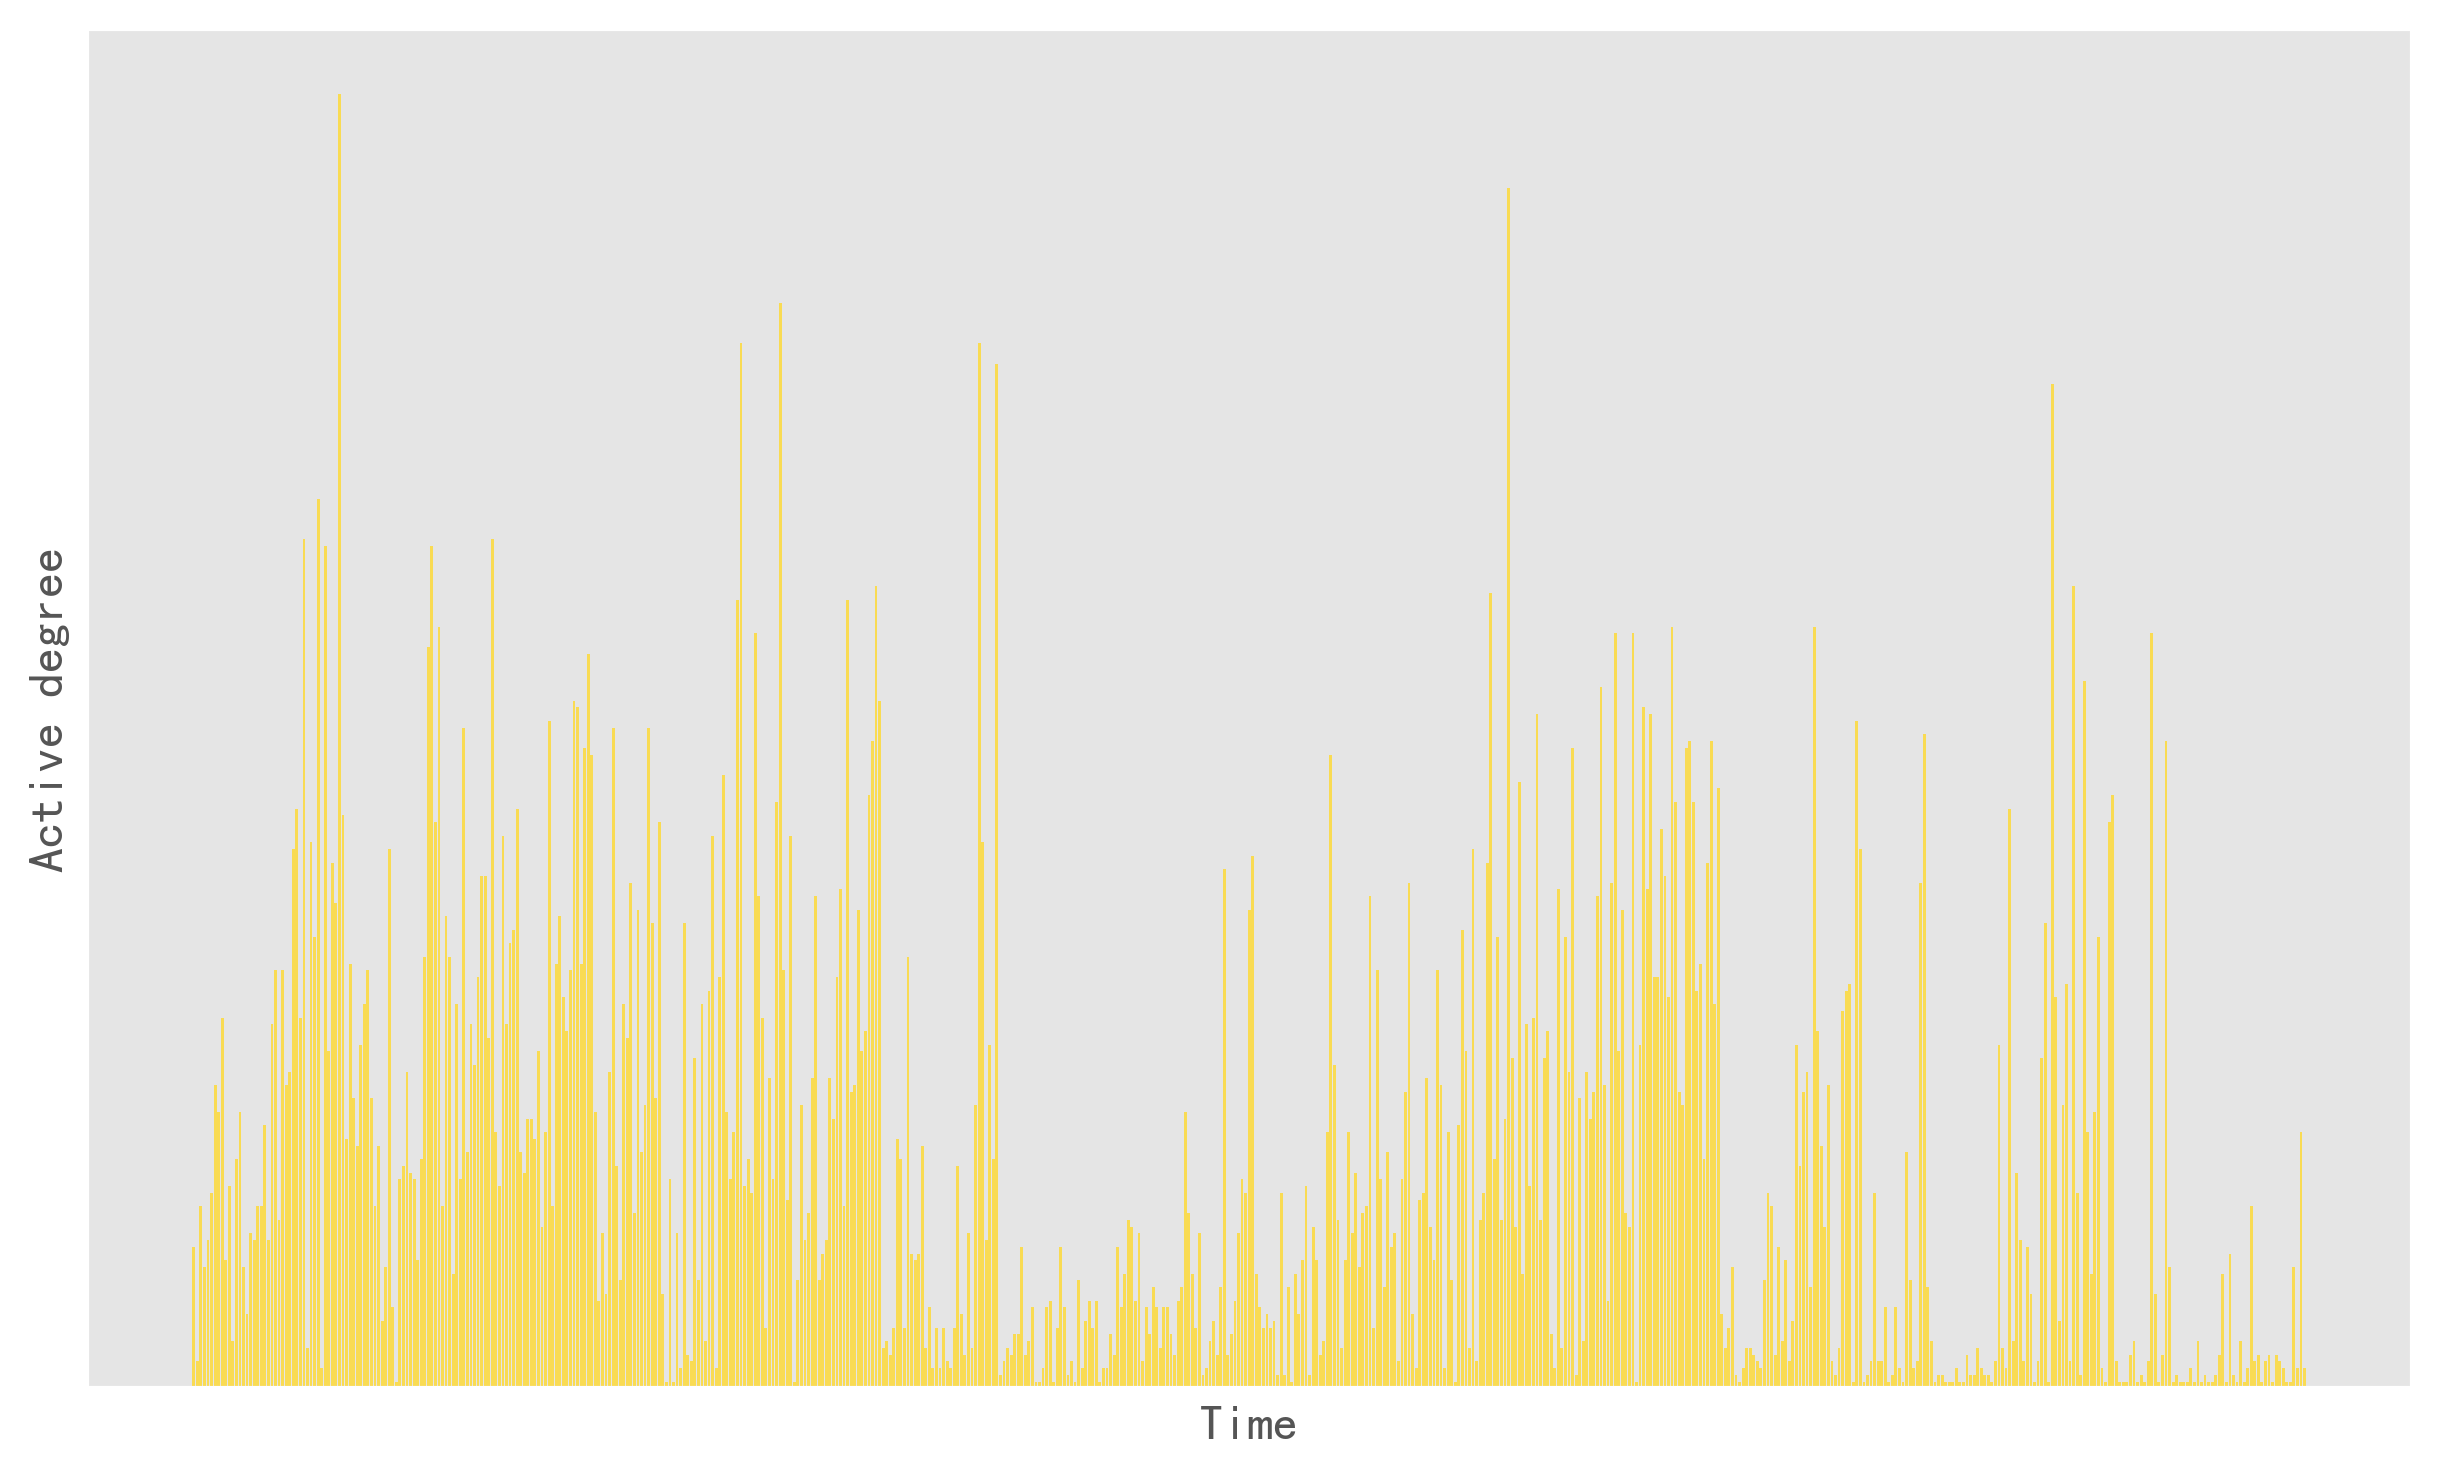

In [11]:
src_all_issue_comment_df = pd.read_csv('./data/Openeuler Src_all_issue_comment.csv') #社区评论的原始数据
comment_time_dict = {}
str_comment_time_dict = {}
re_time = r'(\d{4}-\d\d-\d\d)T\d\d\:\d\d\:\d\d\+08\:00'
src_all_issue_comment_value=src_all_issue_comment_df.values
for src_all_issue_comment in src_all_issue_comment_value:
    re_result = re.search(re_time,src_all_issue_comment[-1])
    if re_result:
        if re_result.group(1) in str_comment_time_dict.keys():
            re_day = datetime.datetime.strptime(re_result.group(1), "%Y-%m-%d")
            comment_time_dict[re_day]+=1
            str_comment_time_dict[re_day.strftime("%Y-%m-%d")]+=1
        else:
            re_day = datetime.datetime.strptime(re_result.group(1), "%Y-%m-%d")
            comment_time_dict[re_day]=1
            str_comment_time_dict[re_day.strftime("%Y-%m-%d")]=1
print("start day: "+str(sorted(comment_time_dict.keys())[0])+", end day: "+str(sorted(comment_time_dict.keys())[-1]))
bar_plot(str_comment_time_dict)

start day: 2019-08-09 00:00:00, end day: 2021-07-29 00:00:00


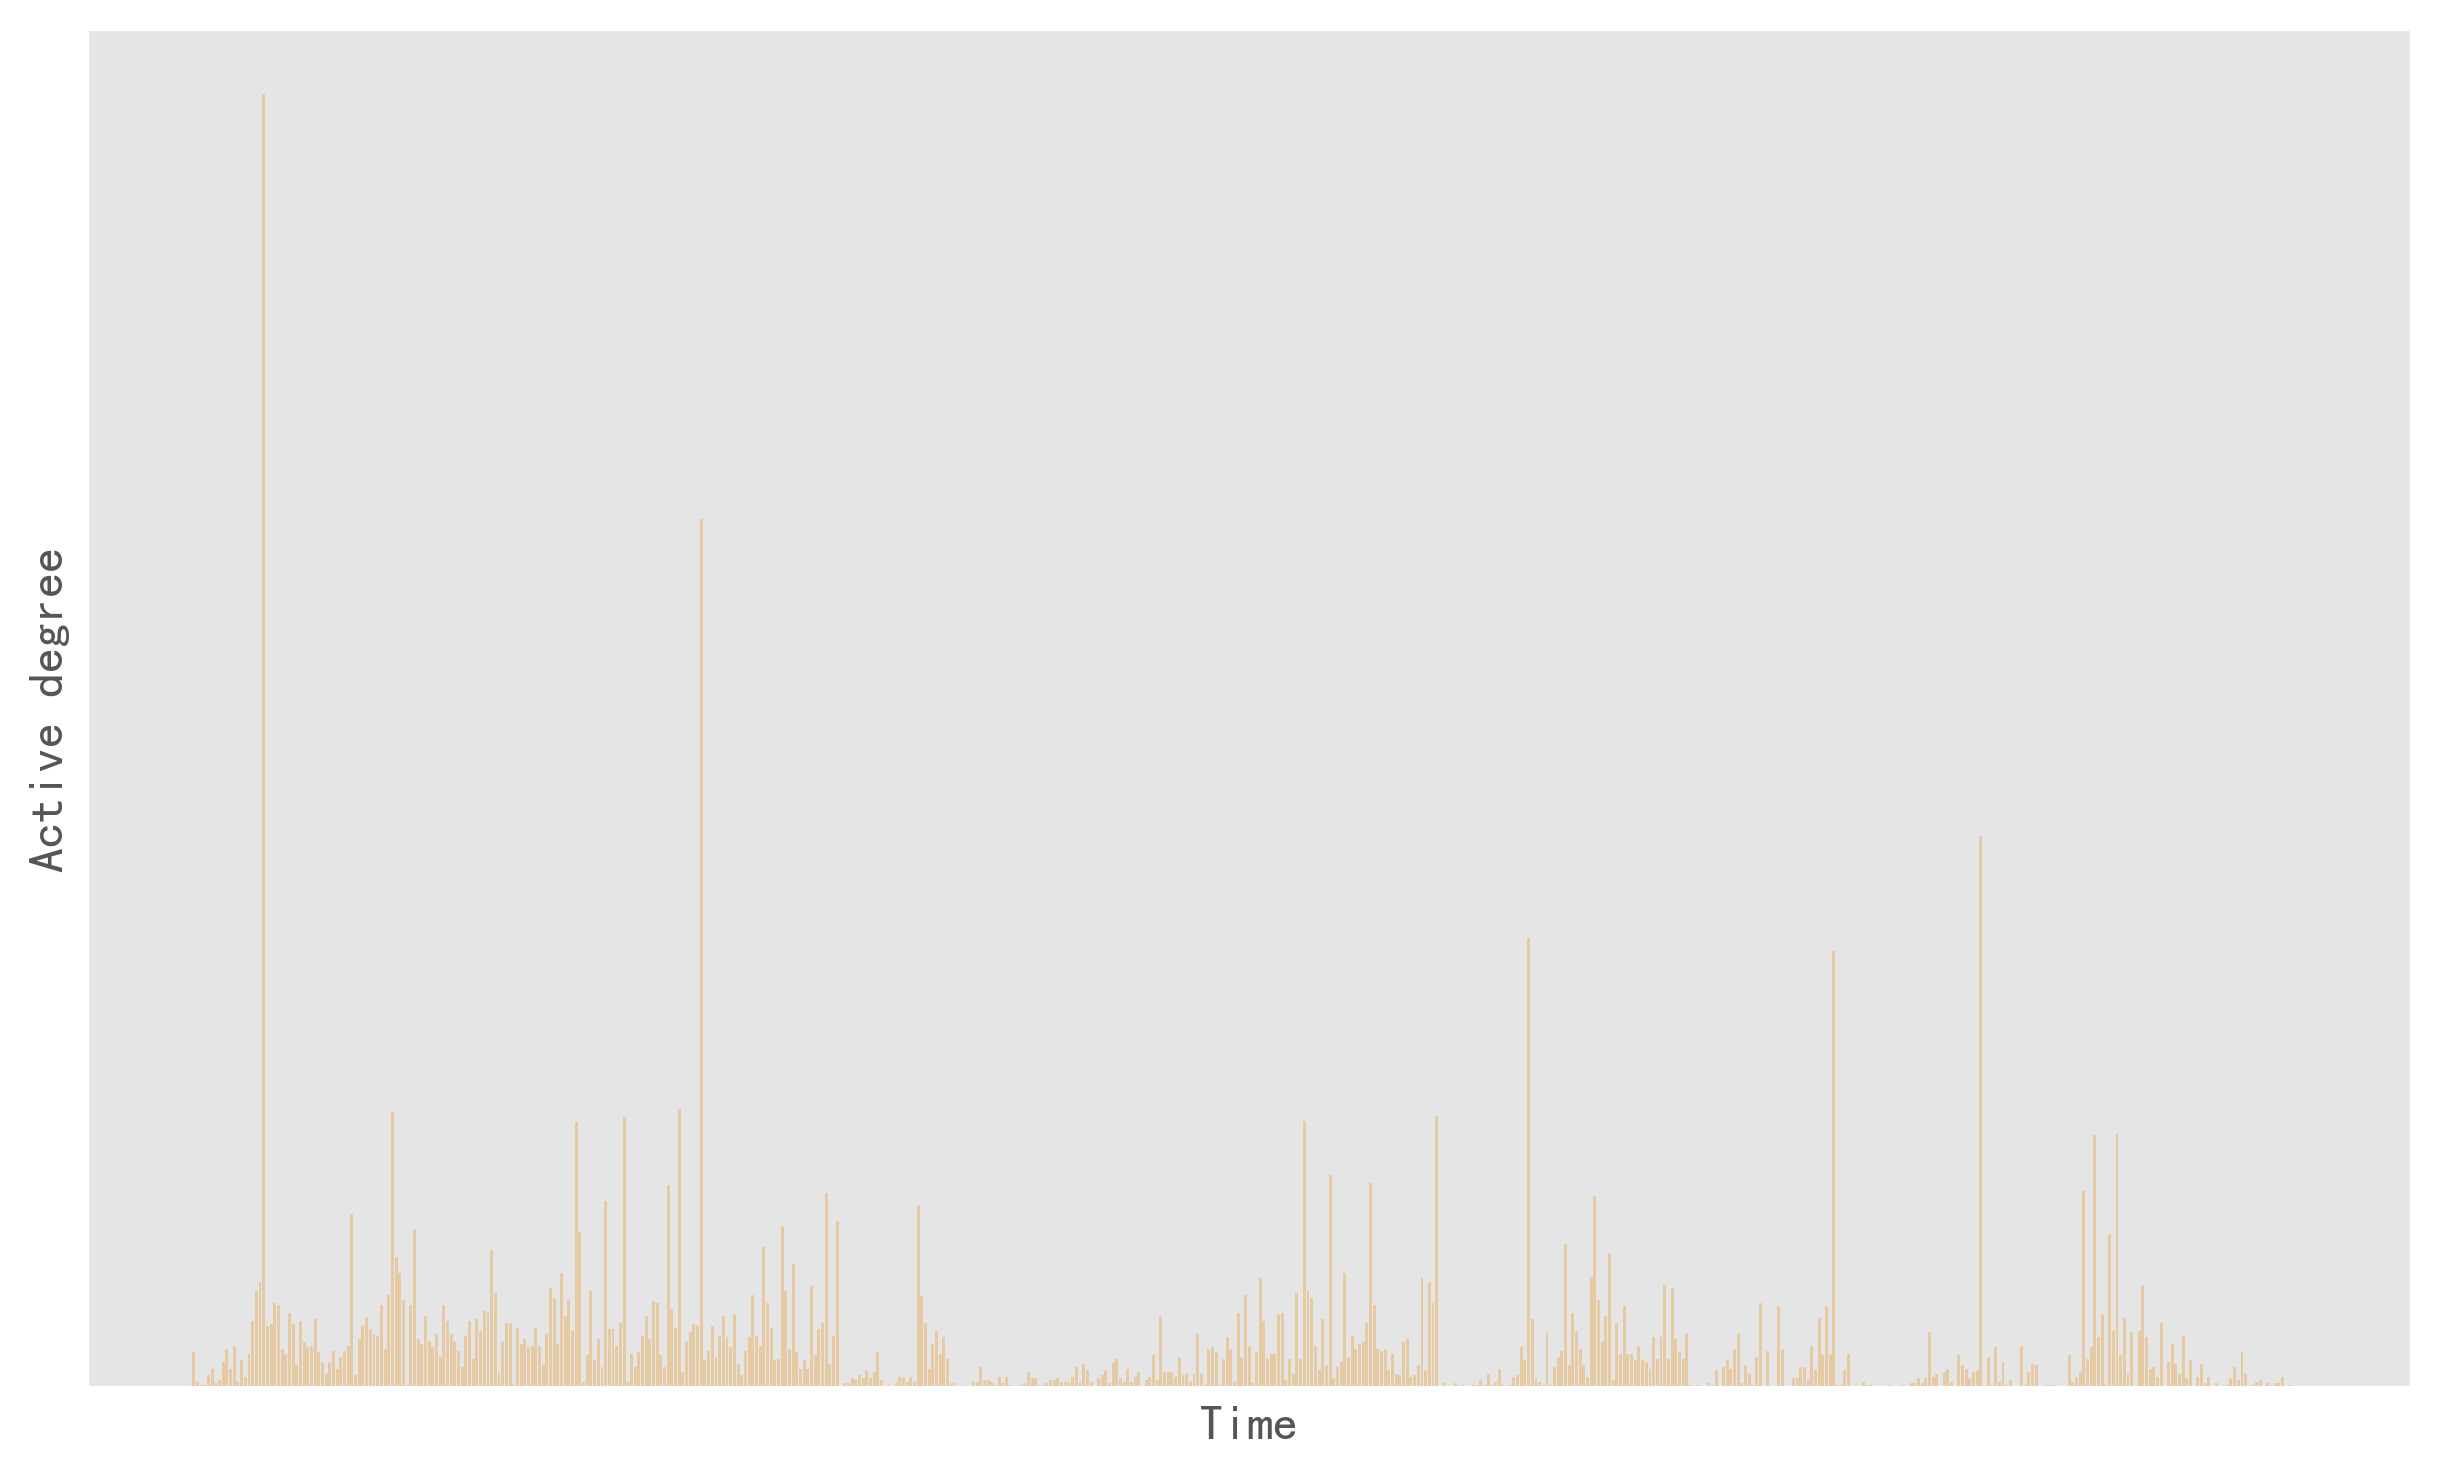

In [12]:
src_all_issue_data_df = pd.read_csv('./data/Openeuler Src_all_issue_data.csv') #社区活动的原始数据
data_time_dict = {}
str_data_time_dict = {}
re_time = r'(\d{4}-\d\d-\d\d) \d\d\:\d\d\:\d\d'
src_all_issue_data_value=src_all_issue_data_df.values
for src_all_issue_data in src_all_issue_data_value:
    re_result = re.search(re_time,src_all_issue_data[-1])
    if re_result:
        if re_result.group(1) in str_data_time_dict.keys():
            re_day = datetime.datetime.strptime(re_result.group(1), "%Y-%m-%d")
            data_time_dict[re_day]+=1
            str_data_time_dict[re_day.strftime("%Y-%m-%d")]+=1
        else:
            re_day = datetime.datetime.strptime(re_result.group(1), "%Y-%m-%d")
            data_time_dict[re_day]=1
            str_data_time_dict[re_day.strftime("%Y-%m-%d")]=1
print("start day: "+str(sorted(data_time_dict.keys())[0])+", end day: "+str(sorted(data_time_dict.keys())[-1]))
bar_plot(str_data_time_dict)

增量和：953


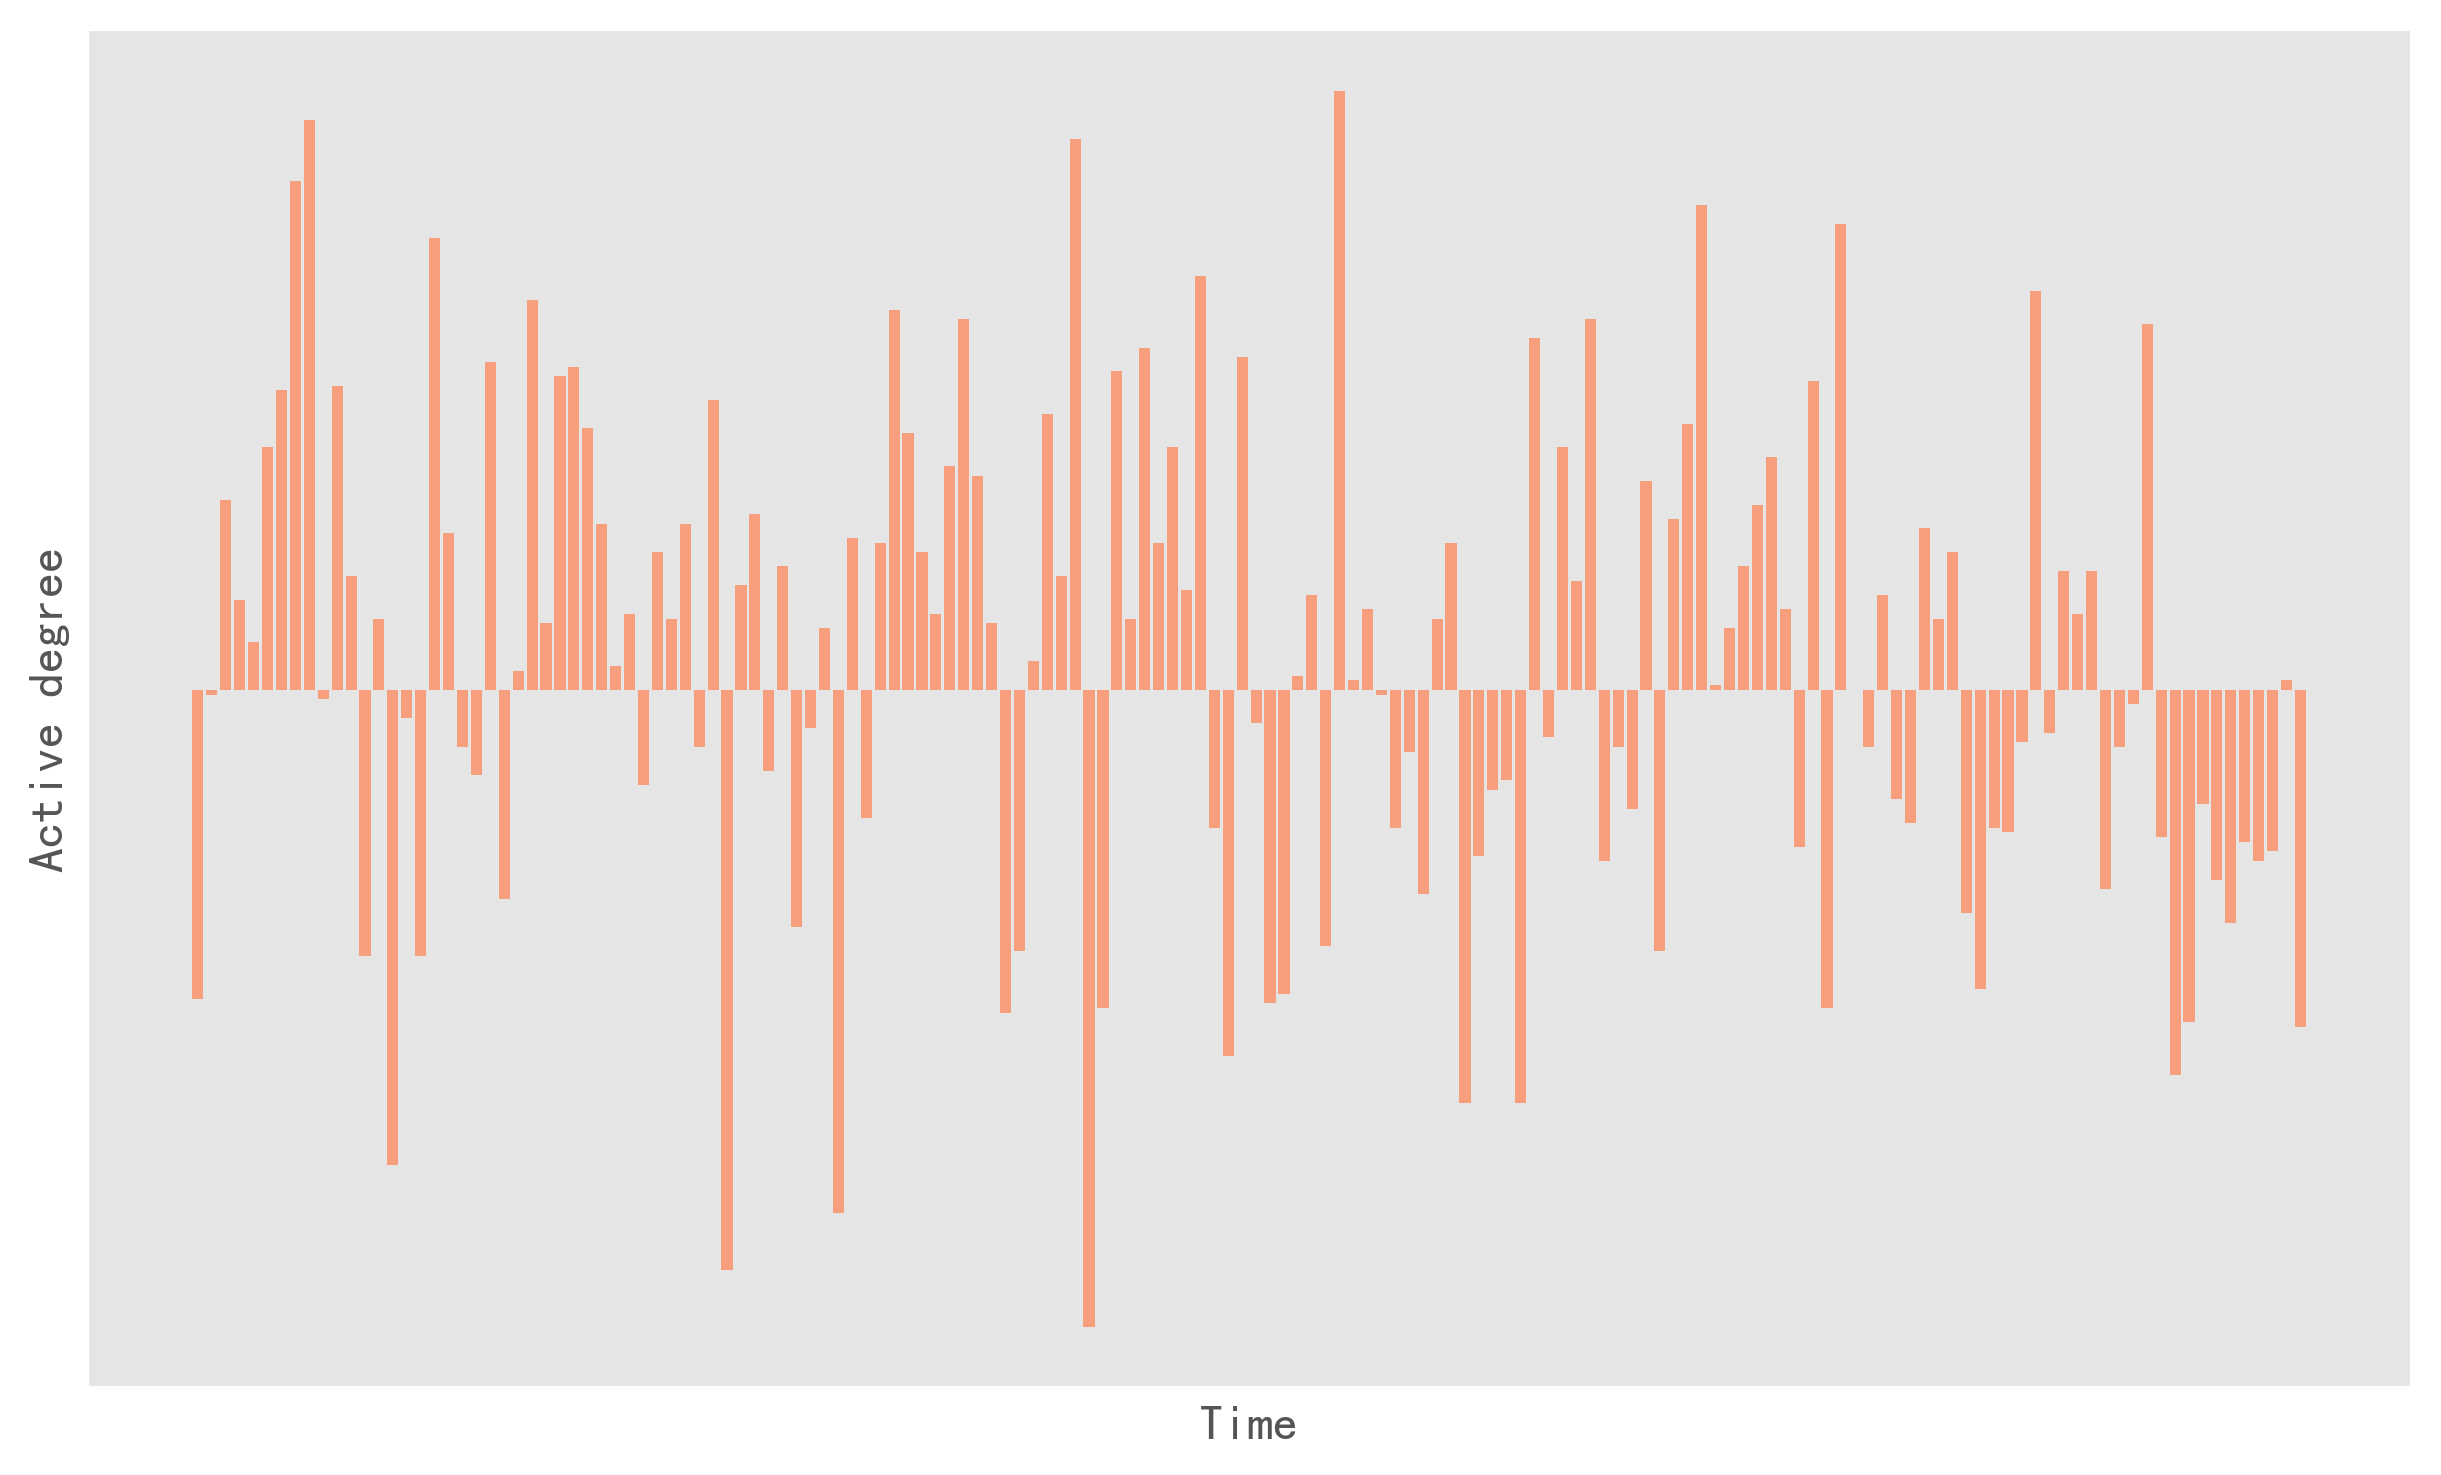

In [13]:
##########模拟的输入数据##########
# 活动主题影响力  topic_impact  float  0-1000
# 举办方运营能力  host_option_number  int  0-1000
# 参与者影响力  people_impact  float  0-1  高斯分布

topic_label_impact_dict={}
for label in topic_label_dict.keys():
    topic_label_impact_dict[label]=np.random.rand(1)
    
host_option_number = 748

##########已有的输出数据##########
# 社区活跃度增量 commu_acti_add 领域相关活跃度增量 topic_acti_add 赛题完成情况 topic_finish
# 这里的增量定义为 当前活跃度 - 一个月前活跃度
days_num = 24
start_day = datetime.datetime.strptime("2020-11-09", "%Y-%m-%d")
end_day = datetime.datetime.strptime("2021-04-23", "%Y-%m-%d")
commu_acti_add_dict = {}
str_commu_acti_add_dict = {}
for key in comment_time_dict:
    if key > start_day and key < end_day:
        if key - datetime.timedelta(days=days_num) not in comment_time_dict.keys():
            past_acti = 0
        else:
            past_acti = comment_time_dict[key - datetime.timedelta(days=days_num)]
        commu_acti_add_dict[key]= comment_time_dict[key] -  past_acti
        str_commu_acti_add_dict[key.strftime("%Y-%m-%d")]= comment_time_dict[key] -  past_acti
print("增量和：{}".format(sum(list(commu_acti_add_dict.values()))))
bar_plot(str_commu_acti_add_dict)

增量和：193


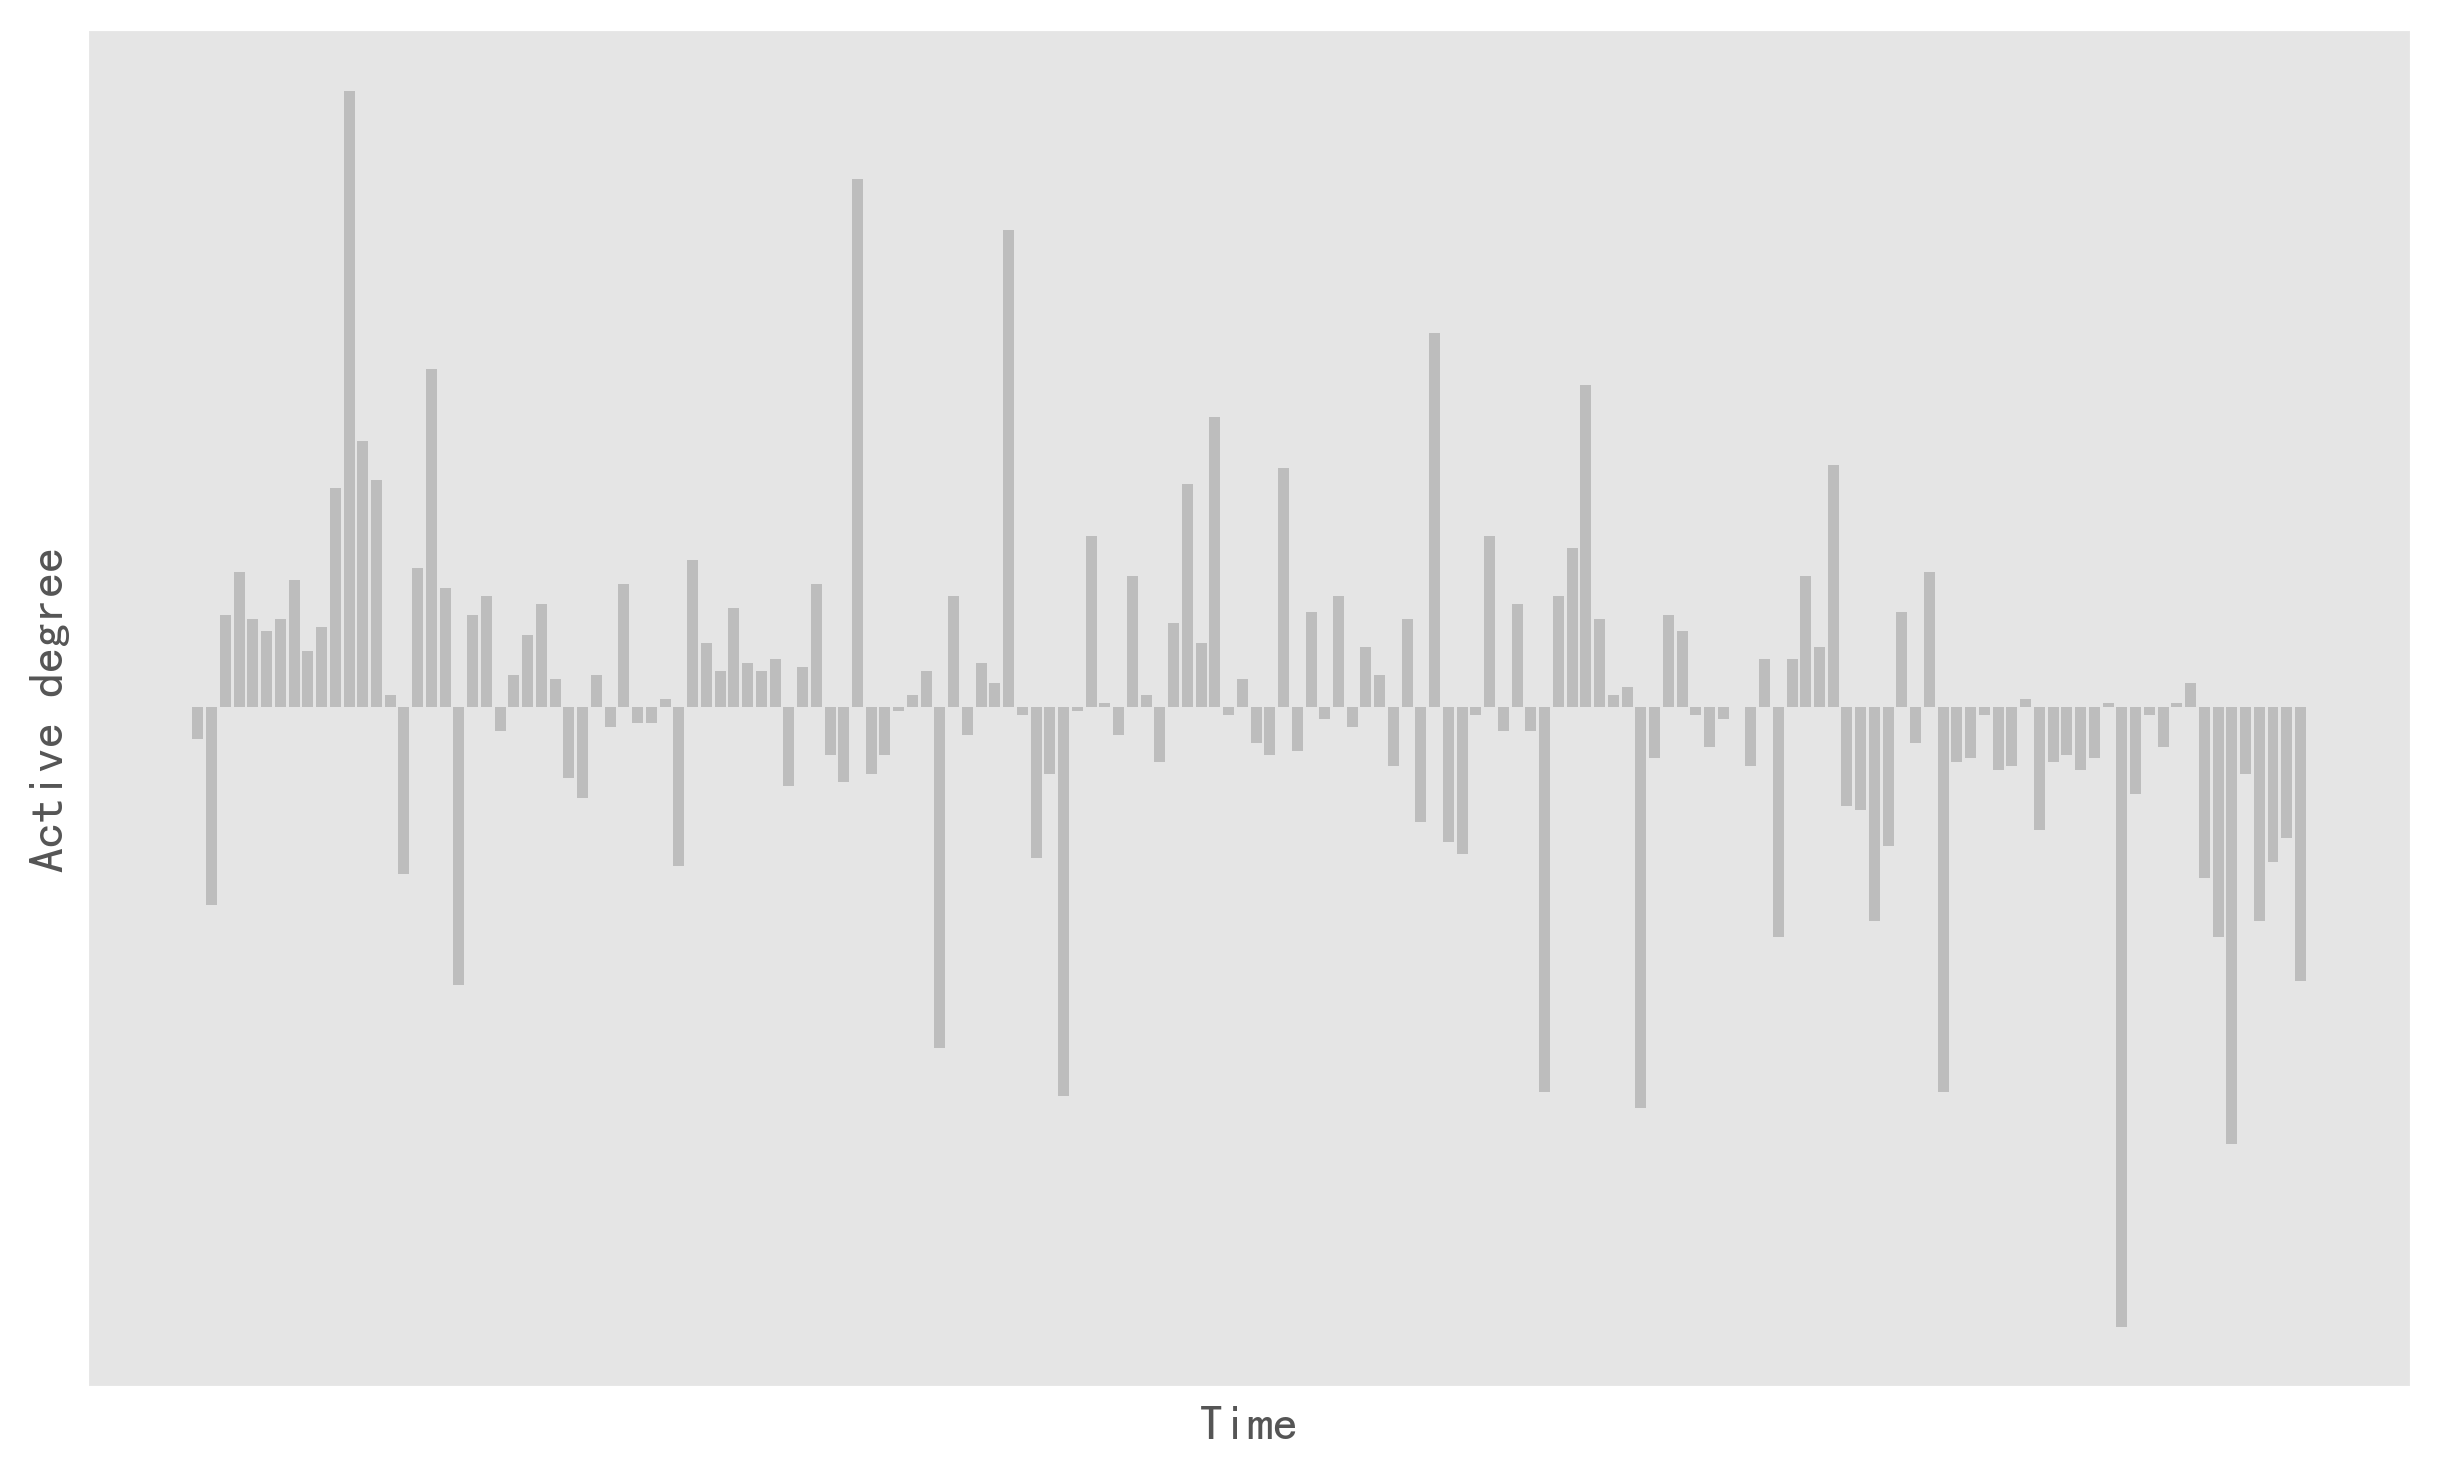

In [14]:
days_num =16
data_acti_add_dict = {}
str_data_acti_add_dict = {}
for key in data_time_dict:
    if key > start_day and key < end_day:
        if key - datetime.timedelta(days=days_num) not in data_time_dict.keys():
            past_acti = 0
        else:
            past_acti = data_time_dict[key - datetime.timedelta(days=days_num)]
        data_acti_add_dict[key]= data_time_dict[key] -  past_acti
        str_data_acti_add_dict[key.strftime("%Y-%m-%d")]= data_time_dict[key] -  past_acti
print("增量和：{}".format(sum(list(data_acti_add_dict.values()))))
bar_plot(str_data_acti_add_dict)

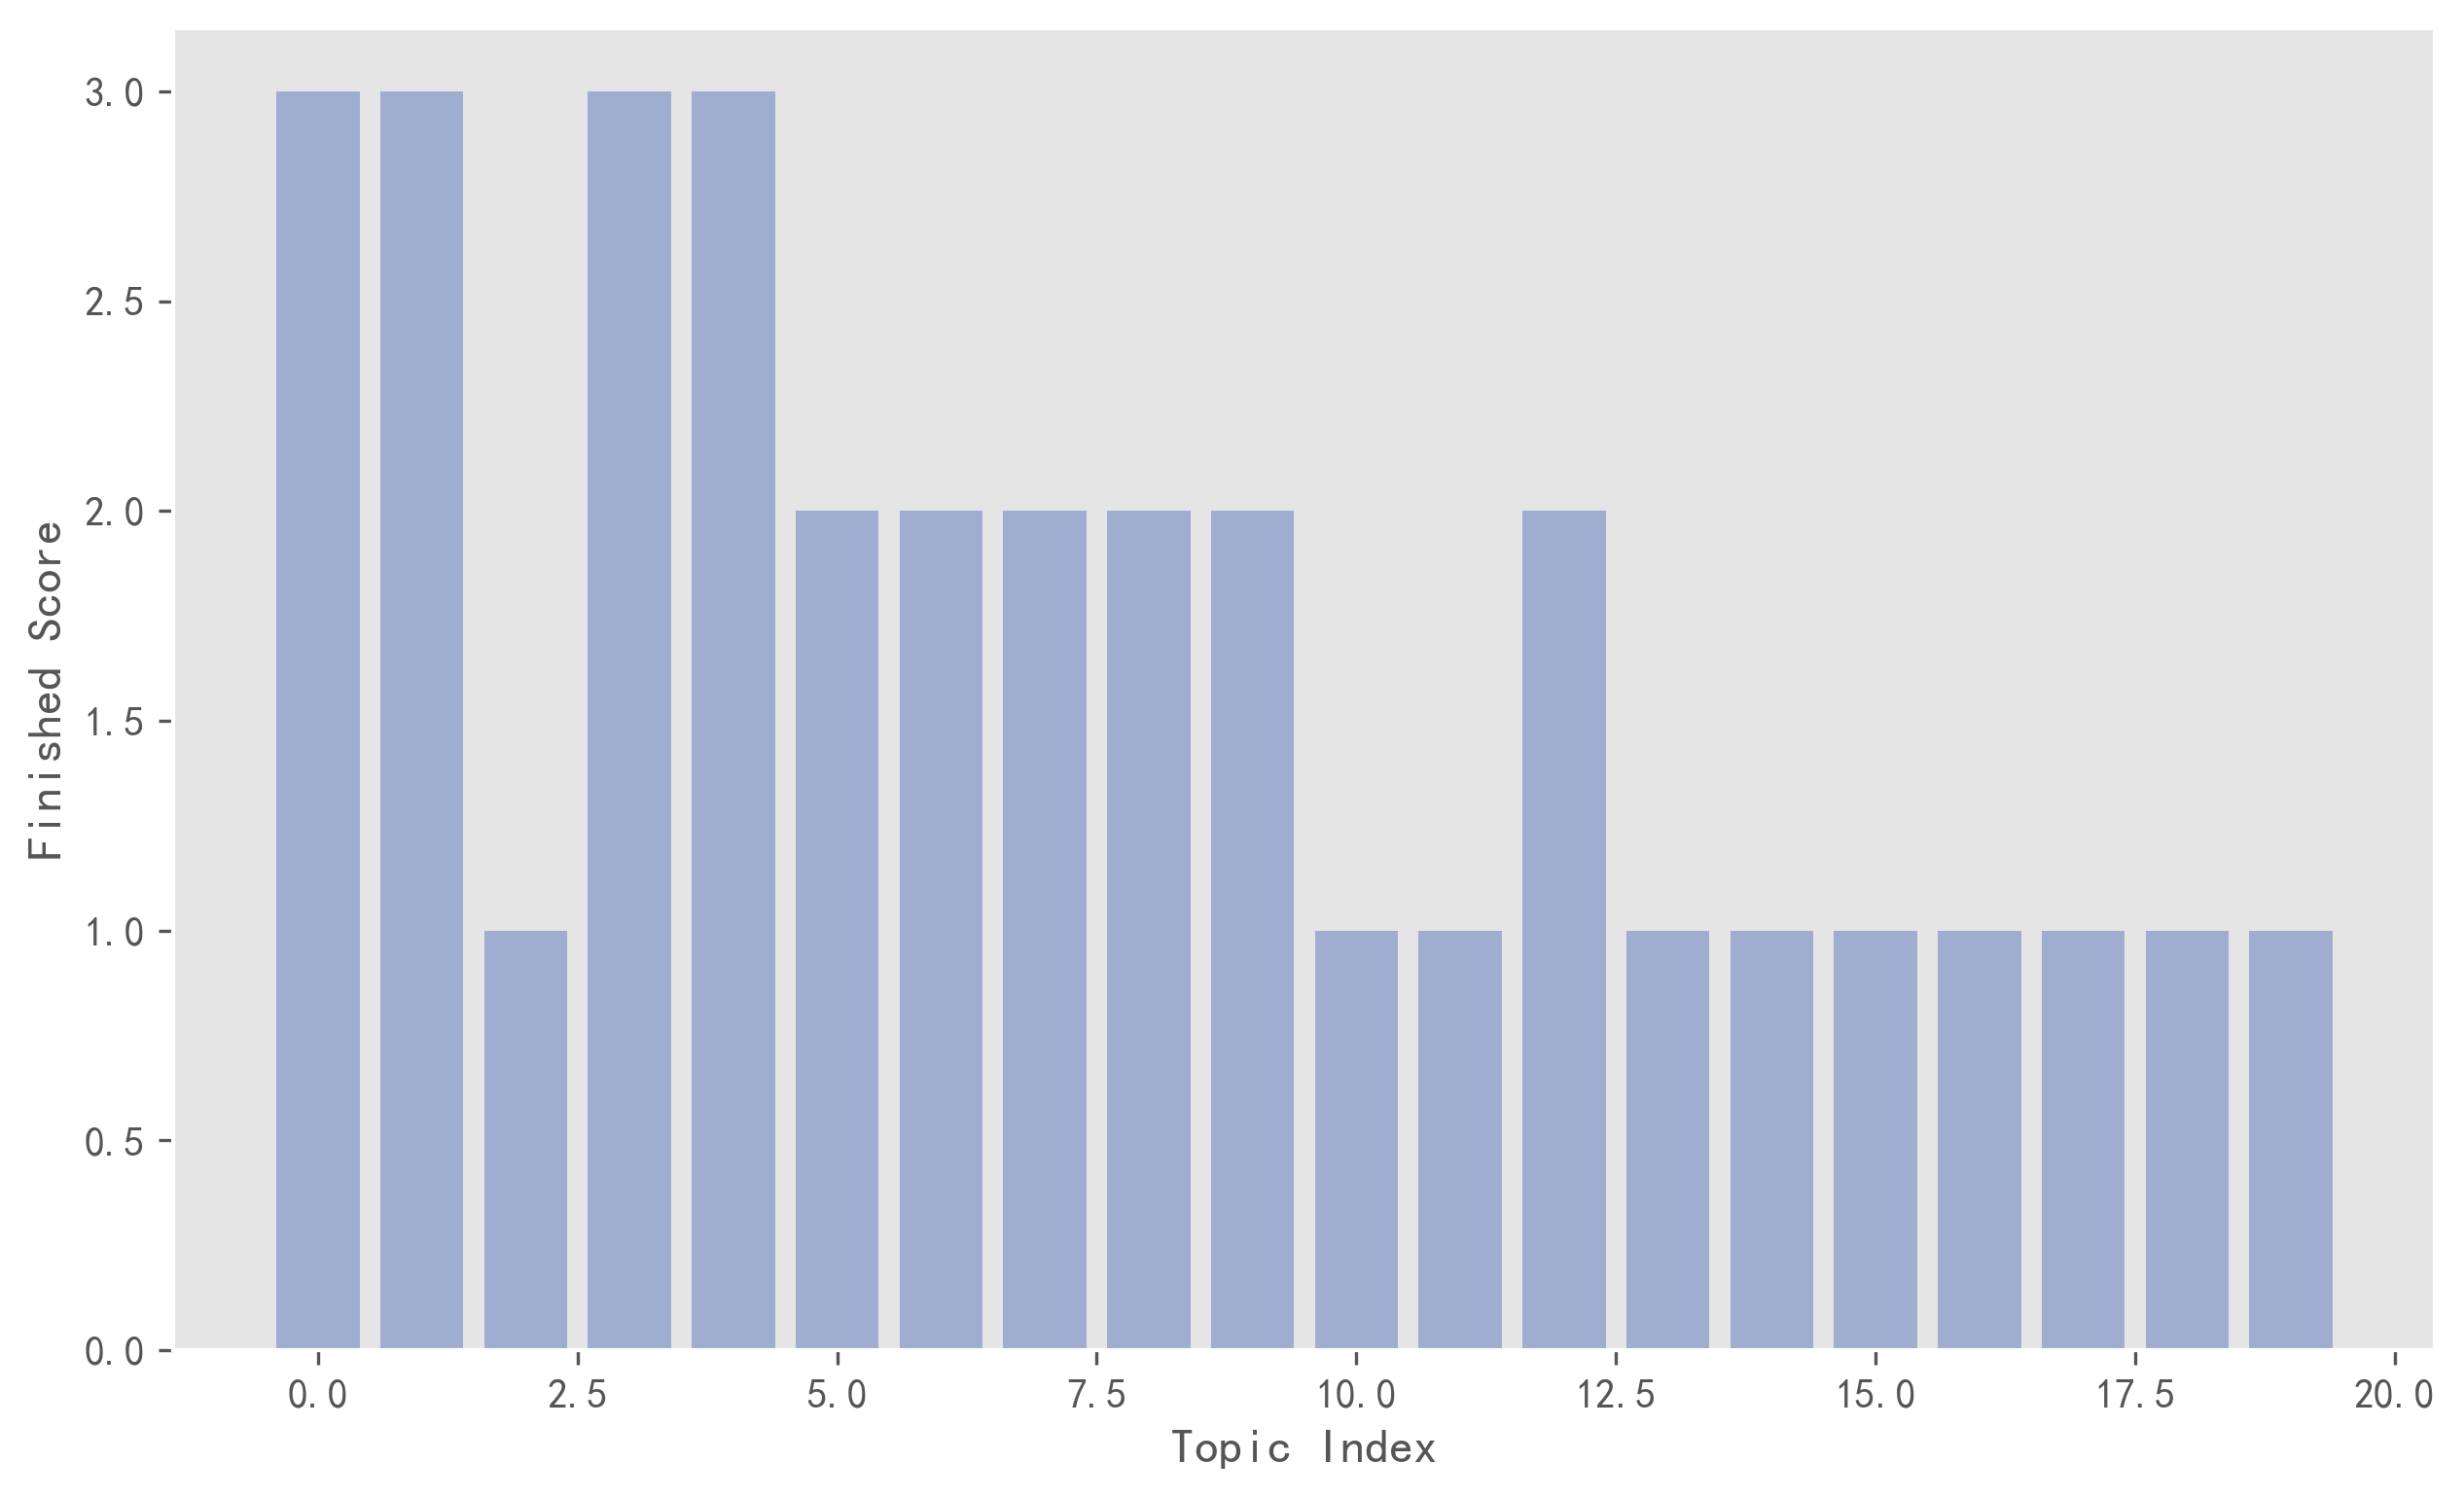

In [15]:
topic_finish = {}
for key,value in team_dict.items():
    if key not in topic_finish.keys():
        for i in team_dict[key]:
            topic_finish[key] = 4 - i
    else:
        for i in team_dict[key]:
            topic_finish[key] += 4 - i
bar_plot(topic_finish, xlabel='Topic Index', ylabel='Finished Score',on_ticks=True)

In [16]:
# 活动时间：2020-11-09   2021-04-23
days_num = end_day.__sub__(start_day).days
times=[]
for i in range(days_num):
    day_i = start_day + datetime.timedelta(days=i)
    times.append(day_i)
    
topic_impact = sum(list(topic_label_impact_dict.values()))

In [19]:
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from numpy import vstack, array, nan
from sklearn.impute import SimpleImputer

# 数据：people_number，host_option_number，topic_label_impact_dict，topic_finish，data_acti_add_dict
#     结果：commu_acti_add_dict
data=pd.DataFrame({
    "people_number":people_number-5+10*np.random.rand(days_num),
    "host_option_number":host_option_number-5+10*np.random.rand(days_num),
    "topic_impact":topic_impact-3+6*np.random.rand(days_num),
    "data_acti_add":np.zeros(days_num)
})
commu_acti_add=np.zeros(days_num)
for i in range(days_num):
    if times[i] in data_acti_add_dict.keys():
        data["data_acti_add"][i]=data_acti_add_dict[times[i]]
    if times[i] in commu_acti_add_dict.keys():
        commu_acti_add[i]=commu_acti_add_dict[times[i]]

for i in range(days_num):
    if commu_acti_add[i]>0:
        commu_acti_add[i]=1
    else:
        commu_acti_add[i]=0
data = MinMaxScaler().fit_transform(data.values)

In [31]:
# AHP  计算指标权重
from evaluation.ahp import ahp_method
# 计算参数
weight_derivation = 'geometric'
# 构造判断矩阵
# c1:people_number    c2:host_option_number   c3:topic_impact    c4:data_acti_add
dataset = np.array([
    # c1   c2    c3    c4
    [1,    1/3,  1/5,  1 ],  # c1
    [3,    1,    1/2,  2 ],  # c2
    [5,    2,    1,    4 ],  # c3
    [1,    1/2,  1/4,  1 ],  # c4
])
# 调用AHP函数
weights, rc = ahp_method(dataset, wd=weight_derivation)

total_score = np.sum(data * weights)
print("评价总分：{}".format(total_score))

评价总分：81.7991950907325


In [3]:
# 指标的因果推断，对指标进行平均处理效应估计
# 内容详见 https://causalml.readthedocs.io/en/latest/examples.html
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

# 模拟数据集
y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)
# 其中，treatment表示该指标是否有参与，如果参与则为1，非参与则为0

# 使用多种方法进行处理效应估计
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.69 (0.54, 0.84)
Average Treatment Effect (XGBoost): 0.57 (0.50, 0.64)
Average Treatment Effect (Neural Network (MLP)): 0.48 (0.36, 0.61)
Average Treatment Effect (BaseRRegressor using XGBoost): 0.58 (0.57, 0.59)
